In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# /kaggle/input/im2latex100k/im2latex_formulas.norm.csv
# /kaggle/input/im2latex100k/im2latex_train.csv
# /kaggle/input/im2latex100k/im2latex_validate.csv
# /kaggle/input/im2latex100k/im2latex_test.csv
# /kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/

In [3]:
!pip install latex

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7588 sha256=533a4b4168ad7a34eb9fd226d378b17f108162c27a6b3eb81b8a1c3522ebefc9
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7227 sha256=8e71d826c7e4ff9baf72bed4fe7cbf565f9ed50f3dbc5e9df2532f0480e060e1
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2763 sha256=4afc72dee1b16e1577b18585a922570a38e3e14f04332bab8f44271b22aaf507
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e018891505911e82a6f358a0291e7681bae
  Created wheel for tempdir: filename=tempdir-0.7.

In [4]:
# !pip install latex
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from torchvision.io import read_image
import latex
import re
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim 
from tqdm import tqdm

In [5]:
df = pd.read_csv('/kaggle/input/im2latex100k/im2latex_test.csv').dropna()
a = df['formula'].unique().sum()
# a
print(df.dropna())
# print(a[0])
print(os.path.join('/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/',df['image'][0]))

                                                 formula           image
0      \alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots ...  7944775fc9.png
1      \eta = - \frac { 1 } { 2 } \operatorname { l n...  78228211ca.png
2      P _ { ( 2 ) } ^ { - } = \int \beta d \beta d ^...  15b9034ba8.png
3      \Gamma ( z + 1 ) = \int _ { 0 } ^ { \infty } \...  6968dfca15.png
4      \frac { d } { d s } { \bf C } _ { i } = \frac ...  6cead0df53.png
...                                                  ...             ...
10350  \nu = \frac { - 2 \beta _ { 1 } } { \beta _ { ...  3caf8fcb25.png
10351  3 \delta _ { l , \, j \pm b _ { r } } = \sum _...  6ed277c793.png
10352  \beta ( \lambda _ { j } ) = ( 2 + \epsilon ) \...  49721f860b.png
10353  E = v \sqrt { Q _ { M } ^ { 2 } + Q _ { E } ^ ...  4cbdf71aaf.png
10354  X _ { 1 \, n - 1 } = \frac { q } { q - q ^ { -...  643602bf3b.png

[10284 rows x 2 columns]
/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/7944775fc9.png


In [6]:
class Vocabulary():
    def __init__(self, freq_th=1):
        self.itos = {0:"[pad]",1:"[sos]",2:"[eos]",3:"[unk]"}
        self.stoi = {"[pad]":0,"[sos]":1,"[eos]":2,"[unk]":3}
        self.freq_th = freq_th
        
        #regex
        self.TOKENIZE_PATTERN = re.compile(
            "(\\\\[a-zA-Z]+)|" + '((\\\\)*[$-/:-?{-~!"^_`\[\]])|' + "(\w)|" + "(\\\\)"
        )
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer(TOKENIZE_PATTERN, formula: str):
        tokens = re.finditer(TOKENIZE_PATTERN, formula)
        tokens = list(map(lambda x: x.group(0), tokens))
        tokens = [x for x in tokens if x is not None and x != ""]
        return tokens
    
    def build_vocabulary(self,sentence_list):
        frequency = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer(self.TOKENIZE_PATTERN,sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (word not in self.stoi and frequency[word] > self.freq_th-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
                    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer(self.TOKENIZE_PATTERN,sentence)
        return [self.stoi[word] if word in self.stoi else self.stoi["[unk]"] for word in tokenized_text ]
                    

In [7]:
v = Vocabulary(1)
v.build_vocabulary(df['formula'].tolist())
len(v.itos)

405

In [8]:
# Preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, freq_threshold=1):
        #initialise paramaters
        self.root_dir = root_dir
        self.transform = transform
        
        # get label and image df
        self.df = pd.read_csv(csv_file).dropna()
        
        # initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df['formula'].tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        # getting image ready
        img_path = os.path.join(self.root_dir,self.df['image'][index])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            
        # getting caption ready
        latex = self.df['formula'][index]
        num_tex = [self.vocab.stoi["[sos]"]]
        num_tex += self.vocab.numericalize(latex)
        num_tex.append(self.vocab.stoi["[eos]"])
        
        # return the pair
        return image,torch.tensor(num_tex)

In [10]:
train_dataset = MyDataset('/kaggle/input/im2latex100k/im2latex_train.csv','/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/',transform)

tensor([  1,  72,  33,  22,  30,  93,  25,   7,  26,  13, 150,   6,   7, 112,
         13,  47,  36,  93,  25,   7,  26,  13, 150,   6,   7, 112,  13,  54,
          2])
[sos] V = - g D ^ { 2 } \Gamma _ { 4 } + H D ^ { 2 } \Gamma _ { 4 } . [eos] 
\sum _ { \alpha \in \Phi } ( \alpha \beta ) ^ { 2 } = \sum _ { \alpha \in P } ( \alpha \beta ) ^ { 2 } = g \beta ^ { 2 } .


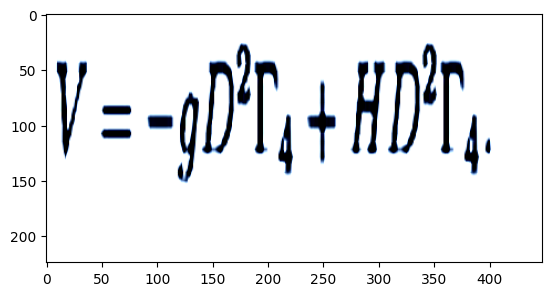

In [11]:
n = 674
b,a = train_dataset.__getitem__(n)
print(a)
s = ""
c=0
for i in a:
    c+=1
    s+=train_dataset.vocab.itos[i.item()]
    s+=" "
print(s)
print(df['formula'][n])
plt.imshow(b.permute(1,2,0))
# plt.imshow(Image.open(os.path.join('/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/',df['image'][0])))

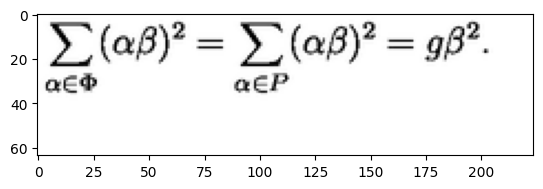

In [12]:
plt.imshow(Image.open(os.path.join('/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/',df['image'][n])).convert('RGB'))

In [13]:
class MyCollate:
    def __init__(self,pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
#         print(batch[0].shape)
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = True, padding_value = self.pad_idx)
        
        return imgs,targets

In [14]:
def get_loader(csv_file, root_dir='/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/', transform=transform, batch_size=32, num_workers=4, shuffle=True, pin_memory=True):
    dataset = MyDataset(csv_file=csv_file,root_dir=root_dir, transform=transform)
    pad_value = dataset.vocab.stoi["[pad]"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=4, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

# Creating Dataloaders

In [15]:
train_loader, train_dataset = get_loader(csv_file = '/kaggle/input/im2latex100k/im2latex_train.csv')
test_loader, test_dataset = get_loader(csv_file = '/kaggle/input/im2latex100k/im2latex_test.csv')
val_loader, val_dataset = get_loader(csv_file = '/kaggle/input/im2latex100k/im2latex_validate.csv')

In [16]:
# l,d = get_loader()

In [17]:
# a ,b= next(iter(l))

In [18]:
# plt.imshow(a[10].permute(1,2,0))

In [19]:
# b[10]

In [20]:
# print(a.shape,b.shape)

In [21]:
class EncoderCnn(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCnn, self).__init__()
        
        #using pretrained model 
        pretrained = models.resnet50(weights=True)
        #freezing training of weights
        for param in pretrained.parameters():
            param.requires_grad = False
            
        #getting all layers in list module and removed the last layer(we will add our own)
        modules = list(pretrained.children())[:-1]
        #putting final layers in out variable
        self.pretrained = nn.Sequential(*modules)
        
        #changing last layer and allow it to train
        self.fc = nn.Linear(pretrained.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.fc.weight.data.normal_(0., 0.02)
        self.fc.bias.data.fill_(0)
        
    def forward(self,images):
        features = self.pretrained(images)
        #flattening to pass to fully connected layer
        features = features.view(features.size(0),-1)
        features = self.batch(self.fc(features))
        return features  #[batch, embed_size]
    

In [22]:
class DecoderRnn(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(DecoderRnn, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) #[batch,seq] -> [batch,seq,embed]
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,batch_first=True) #[batch,seq,embed]->hiddens[batch,seq,hidden_size]
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption)) #[batch,seq] -> [batch,seq,embed]
#         print(embeddings.shape)
#         print(features.shape)
#         z = features.unsqueeze(1)
#         print(z.shape)
        embeddings = torch.cat((features.unsqueeze(1),embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [23]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = EncoderCnn(embed_size)
        self.decoderRNN = DecoderRnn(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=200):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            print(x)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
#                 print(predicted)
                result_caption.append(predicted.item())
#                 print(output.shape)
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)
#                 print("x",x)
                if vocabulary.itos[predicted.item()] == "[eos]":
                    break
        return [vocabulary.itos[i] for i in result_caption]

In [24]:
save_model = True
step = 0
embed_size = 300
hidden_size = 300
num_layers = 2
num_epochs = 5
learning_rate = 1e-3
vocab_size = len(train_dataset.vocab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [26]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["[pad]"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [27]:
imgs,captions = next(iter(train_loader))
imgs.shape, captions.shape

(torch.Size([32, 3, 224, 448]), torch.Size([32, 125]))

In [28]:
model.train()

for epoch in range(num_epochs):
    for imgs, captions in tqdm(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)

        score = model(imgs, captions[:,:-1])
    #         print(score.shape,captions.shape)
    #         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
    #         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))


        step += 1

        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

100%|██████████| 2353/2353 [04:58<00:00,  7.87it/s]


Loss for epoch 0: 1.6755130290985107


100%|██████████| 2353/2353 [04:57<00:00,  7.91it/s]


Loss for epoch 1: 1.876245141029358


100%|██████████| 2353/2353 [04:57<00:00,  7.90it/s]


Loss for epoch 2: 2.0035390853881836


100%|██████████| 2353/2353 [04:57<00:00,  7.91it/s]


Loss for epoch 3: 1.645411491394043


100%|██████████| 2353/2353 [04:57<00:00,  7.90it/s]

Loss for epoch 4: 1.359038233757019


In [29]:
torch.save(model.state_dict(), '/kaggle/working/image_to_latex.pth')
print('Model saved to /kaggle/working/image_to_latex.pth')

Model saved to /kaggle/working/image_to_latex.pth


tensor([[[ 4.4596e-01,  9.6070e-01,  1.7017e-01, -1.5745e-01,  1.9754e+00,
          -1.1937e+00, -2.3474e-01,  1.5219e+00,  1.5971e-01,  5.0456e-01,
           7.6628e-01,  2.4623e-01, -3.4650e-01, -4.3162e-02,  2.3322e-01,
           1.8955e-02,  8.2794e-02,  5.1315e-02,  3.9106e-01,  1.9251e-01,
          -5.5653e-01, -2.1668e-01, -3.1748e-01,  1.7394e+00,  4.6057e-01,
          -2.2718e-01, -1.5758e-01,  1.0650e+00,  3.7845e-01, -5.0139e-01,
           6.3222e-02,  4.6094e-01,  1.0290e+00, -2.3419e-01,  2.1672e-01,
           2.0847e-01,  2.5912e+00,  4.7659e-01, -1.6481e+00,  5.5272e-02,
           7.2034e-01, -8.3969e-02, -3.9396e-01,  1.3842e+00, -1.7927e+00,
           2.9193e-02, -3.4942e-01, -9.9590e-01, -5.5240e-01,  6.0339e-02,
           7.6325e-01,  5.9530e-01, -9.2044e-01,  7.4777e-01, -1.2426e+00,
           1.5383e-01, -3.6583e-01, -2.8423e-01,  1.9534e+00, -4.8618e-01,
          -1.2155e-01,  1.1374e+00, -3.4255e-01,  7.0268e-01, -5.6545e-01,
           5.7141e-01, -4

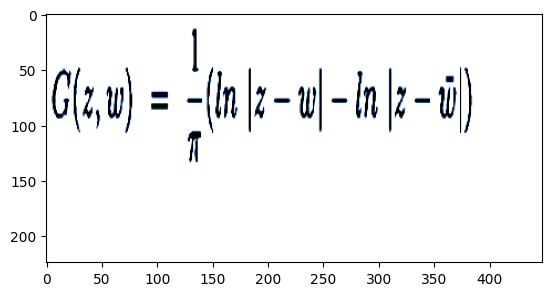

In [30]:
img,c = next(iter(train_loader))
img  = img.cpu()
c = c.cpu()
n = 11
plt.imshow(img[n].permute(1,2,0))
img = img[n].unsqueeze(0).to(device)
c = c[n].unsqueeze(0).to(device)

cap = c.cpu()
cap = cap.numpy()[0]

cap = [train_dataset.vocab.itos[i] for i in cap]
s = ""
for i in cap:
    s+=i
    s+=" "




model.eval()
cap = model.captionImage(image=img, vocabulary=train_dataset.vocab)
print(s)
s = ""
for i in cap:
    s+=i
    s+=" "
print(s)

(64, 320, 3)


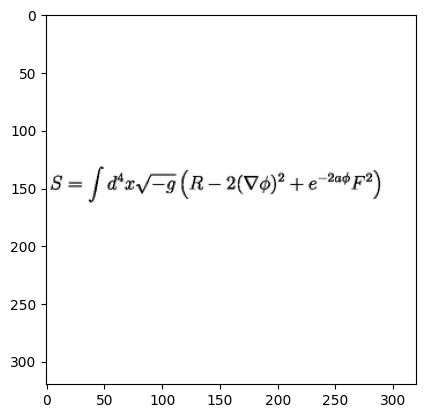

In [31]:
import cv2
import numpy as np

def pad_to_equal(image):
    # Get the dimensions of the image
    print(image.shape)
    h, w ,_= image.shape
    
    # Determine the larger dimension
    max_dim = max(h, w)
    
    # Calculate the padding required for each dimension
    pad_height = max_dim - h
    pad_width = max_dim - w
    
    # Calculate the padding amounts for top, bottom, left, and right
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    # Create a white background for padding
    padded_image = np.ones((max_dim, max_dim, 3), dtype=np.uint8) * 255
    
    # Insert the original image into the padded background
    padded_image[pad_top:pad_top+h, pad_left:pad_left+w] = image
    
    return padded_image


# Load the image
image = cv2.imread(os.path.join('/kaggle/input/im2latex100k/formula_images_processed/formula_images_processed/',df['image'][342]))
# Pad the image
padded_image = pad_to_equal(image)

padded_image.shape
# Show the original and resized images
plt.imshow(torch.tensor(padded_image))